In [2]:
import numpy as np
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import joblib
import matplotlib.pyplot as plt

In [3]:
window_i = 20
window_l = 80 # 32 40 48 56 64 72 80

def data_load(a):   # load data of one persons' 7 motion. a = '\chx_'
    ra = 'ra'
    rd = 'rd'
    sa = 'sa'
    sd = 'sd'
    sit = 'sit'
    stand = 'stand'
    walk = 'walk'

    data_ra = sio.loadmat(r'D:\data\zpk'+a+ra)[ra]
    data_rd = sio.loadmat(r'D:\data\zpk'+a+rd)[rd]
    data_sa = sio.loadmat(r'D:\data\zpk'+a+sa)[sa]
    data_sd = sio.loadmat(r'D:\data\zpk'+a+sd)[sd]
    data_sit = sio.loadmat(r'D:\data\zpk'+a+sit)[sit]
    data_stand = sio.loadmat(r'D:\data\zpk'+a+stand)[stand]
    data_walk = sio.loadmat(r'D:\data\zpk'+a+walk)[walk]
    return data_ra, data_rd, data_sa, data_sd, data_sit, data_stand, data_walk

def get_feature(data):  # calculate features
    feature = np.zeros(((data.shape[1] - window_l)//window_i + 1, 25), dtype = float)
    for i in range(5):
        for j in range((data.shape[1] - window_l) // window_i):
            feature[j, 5 * i] = np.mean(data[i, window_i*j : window_i*j + window_l])
            feature[j, 5 * i + 1] = np.std(data[i, window_i*j : window_i*j + window_l])
            feature[j, 5 * i + 2] = np.var(data[i, window_i*j : window_i*j + window_l])
            feature[j, 5 * i + 3] = np.mean(abs(data[i, window_i*j : window_i*j + window_l] - np.mean(data[i, window_i*j : window_i*j + window_l])))
            feature[j, 5 * i + 4] = max(data[i, window_i*j : window_i*j + window_l]) - min(data[i, window_i*j : window_i*j + window_l])
    return feature

data_ra = []
data_rd = []
data_sa = []
data_sd = []
data_sit = []
data_stand = []
data_walk = []

data = data_load('\zpk_')
data_ra.extend(data[0])
data_rd.extend(data[1])
data_sa.extend(data[2])
data_sd.extend(data[3])
data_sit.extend(data[4])
data_stand.extend(data[5])
data_walk.extend(data[6])

data_ra = np.array(data_ra)
data_rd = np.array(data_rd)
data_sa = np.array(data_sa)
data_sd = np.array(data_sd)
data_sit = np.array(data_sit)
data_stand = np.array(data_stand)
data_walk = np.array(data_walk) # raw data, all data of the same motion

#print(data_ra.shape)

f_data = []
label = []

f_sit = get_feature(data_sit.T)
f_stand = get_feature(data_stand.T)
f_walk = get_feature(data_walk.T)
f_stairA = get_feature(data_sa.T)
f_stairD = get_feature(data_sd.T)
f_rampA = get_feature(data_ra.T)
f_rampD = get_feature(data_rd.T)

for i in range(f_sit.shape[0]):
    label.append(0)

for i in range(f_stand.shape[0]):
    label.append(1)

for i in range(f_walk.shape[0]):
    label.append(2)

for i in range(f_stairA.shape[0]):
    label.append(3)

for i in range(f_stairD.shape[0]):
    label.append(4)

for i in range(f_rampA.shape[0]):
    label.append(5)

for i in range(f_rampD.shape[0]):
    label.append(6)

f_data = np.concatenate((f_sit, f_stand, f_walk, f_stairA, f_stairD, f_rampA, f_rampD), axis = 0)
print(f_data.shape)
print(len(label))

(8428, 25)
8428


In [20]:
train_data_r, test_data_r, train_label, test_label = train_test_split(f_data, label, test_size = 0.2, random_state = 0)
scaler = preprocessing.StandardScaler().fit(train_data_r)
train_data = scaler.transform(train_data_r)
test_data = scaler.transform(test_data_r)
'''
c = svm.SVC(C = 52, kernel = 'rbf', gamma = 0.1, decision_function_shape = 'ovr')
c.fit(train_data, train_label)
print("train acc:", c.score(train_data, train_label))
print('test acc:', c.score(test_data, test_label))
test_pred = c.predict(test_data)
print(confusion_matrix(test_label, test_pred))
'''
parameters = {'gamma':[0.0001, 0.001, 0.01, 0.1, 1, 10], 'C':np.linspace(1, 100, 100)}
gs = GridSearchCV(svm.SVC(), parameters, refit = True, cv = 5, verbose = 1, n_jobs = -1)
gs.fit(train_data, train_label)
print('best parameter: ', gs.best_params_)
print('best efficience:', gs.best_score_)
print('report: ', classification_report(test_label, gs.predict(test_data_r)))

Fitting 5 folds for each of 600 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   54.2s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  6.4min finished


best parameter:  {'C': 13.0, 'gamma': 0.1}
best efficience: 0.9909522396914862
report:                precision    recall  f1-score   support

           0       0.00      0.00      0.00       247
           1       0.00      0.00      0.00       249
           2       0.00      0.00      0.00       572
           3       0.10      1.00      0.19       175
           4       0.00      0.00      0.00       190
           5       0.50      0.01      0.02       131
           6       0.00      0.00      0.00       122

    accuracy                           0.10      1686
   macro avg       0.09      0.14      0.03      1686
weighted avg       0.05      0.10      0.02      1686



D:\anaconda\install\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [5]:
train_data_r, test_data_r, train_label, test_label = train_test_split(f_data, label, test_size = 0.2, random_state = 0)
scaler = preprocessing.StandardScaler().fit(train_data_r)
train_data = scaler.transform(train_data_r)
test_data = scaler.transform(test_data_r)

In [6]:
c = svm.SVC(C = 13, kernel = 'rbf', gamma = 0.1, decision_function_shape = 'ovr')# 
c.fit(train_data, train_label)
print("train acc:", c.score(train_data, train_label))
print('test acc:', c.score(test_data, test_label))
test_pred = c.predict(test_data)
print(confusion_matrix(test_label, test_pred))

joblib.dump(c, "zpk_ion_model.m")

train acc: 0.9980717887867102
test acc: 0.9928825622775801
[[247   0   0   0   0   0   0]
 [  0 249   0   0   0   0   0]
 [  0   0 569   1   0   0   2]
 [  0   0   0 172   3   0   0]
 [  0   0   0   2 187   0   1]
 [  0   0   1   1   0 129   0]
 [  0   0   1   0   0   0 121]]


['zpk_ion_model.m']

In [7]:
t_ra = sio.loadmat(r'D:\data\motion_trans\t_ra')['t_ra']
t_rd = sio.loadmat(r'D:\data\motion_trans\t_rd')['t_rd']
t_sa = sio.loadmat(r'D:\data\motion_trans\t_sa')['t_sa']
t_sd = sio.loadmat(r'D:\data\motion_trans\t_sd')['t_sd']
t_sit = sio.loadmat(r'D:\data\motion_trans\t_sit')['t_sit']
t_stand = sio.loadmat(r'D:\data\motion_trans\t_stand')['t_stand']
t_walk = sio.loadmat(r'D:\data\motion_trans\t_walk')['t_walk']

data_series = np.concatenate((t_sit, t_stand, t_walk, t_ra, t_walk, t_rd, t_walk, t_sa, t_walk, t_sd), axis = 0)
fea_series = get_feature(data_series.T)
t_label = []
for i in range(t_sit.shape[0]):
    t_label.append(0)
for i in range(t_stand.shape[0]):
    t_label.append(1)
for i in range(t_walk.shape[0]):
    t_label.append(2)
for i in range(t_ra.shape[0]):
    t_label.append(5)
for i in range(t_walk.shape[0]):
    t_label.append(2)
for i in range(t_rd.shape[0]):
    t_label.append(6)
for i in range(t_walk.shape[0]):
    t_label.append(2)
for i in range(t_sa.shape[0]):
    t_label.append(3)
for i in range(t_walk.shape[0]):
    t_label.append(2)
for i in range(t_sd.shape[0]):
    t_label.append(4)

print(data_series.shape)
print(len(t_label))
print(fea_series.shape)

clf = joblib.load('zpk_ion_model.m') 
fea_series_nor = scaler.transform(fea_series)
y = clf.predict(fea_series_nor)

(2690, 5)
2690
(131, 25)


In [8]:
y_t = []
for j in range((len(t_label) - window_l) // window_i):
    y_t.append(t_label[j * window_i + window_l - 1])
    
print(y_t)
print(y)


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
[0 0 0 0 0 0 0 0 0 0 0 0 5 5 5 1 1 1 1 1 1 1 1 1 1 1 1 3 3 3 2 2 2 2 2 2 2
 2 2 2 2 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 2 2 2 2 2 2 2 2 2 2 2 5 5 6 6 6 6 6
 6 6 6 6 5 2 5 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 3 2 2 2
 2 2 2 2 2 2 2 2 3 3 3 4 4 4 4 4 4 4 4 3]


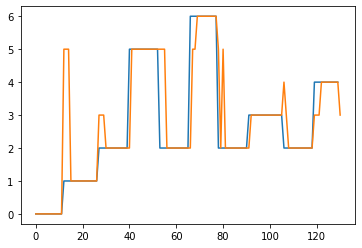

In [11]:
plt.plot(y_t)
plt.plot(y)
plt.savefig('motion_trans_80points.jpg')
plt.show()
